Image classification on the CIFAR-10 Dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Sequentially apply transformations to the input
transform = transforms.Compose(
    [transforms.ToTensor(), # numpy to torch tensor
     # Normalize the image pixel values
     transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

  cat  deer horse   dog


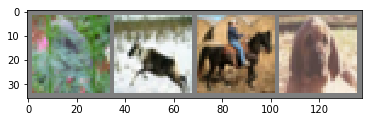

In [5]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define the same CNN as the previous tutorial

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Loss function and optimizer


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Specify which are the set of parameters that are learnable
# Specify the LR and momentum
optimizer = optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9) 


### Train the network
Need to loop over the data, which is on disk using the `trainloader` Dataloader util

In [8]:
n_epochs = 1

In [9]:
for epoch in range(n_epochs):
    
    # initializing the loss
    running_loss = 0.0
    
    # getting the data
    for i, data in enumerate(trainloader): # trainloader takes care of the mini-batch processing
        inputs, labels = data
   
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)    
        # compute gradients
        loss.backward()
        # update weights
        optimizer.step()
        
        running_loss += loss.item() # accumulate loss for the epoch
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss per batch: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000)) 
            
            running_loss = 0.0 # reset to zero
            
print('Finished Training')
    
    

[1,  2000] loss per batch: 2.162
[1,  4000] loss per batch: 1.828
[1,  6000] loss per batch: 1.653
[1,  8000] loss per batch: 1.555
[1, 10000] loss per batch: 1.504
[1, 12000] loss per batch: 1.444
Finished Training


### Testing Phase
Load some test samples

GroundTruth:    cat  ship  ship plane


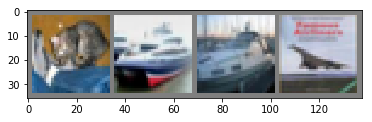

In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

For the above images, we can look at the predictions:

In [11]:
outputs = net(images)
outputs # logit values

tensor([[-1.5728, -2.3038,  1.6891,  2.4784,  0.5867,  1.1101,  1.8512, -1.4143,
         -1.4679, -1.9454],
        [ 4.1245,  4.5637, -1.6457, -2.6144, -1.9963, -3.5224, -2.9284, -3.9041,
          6.1619,  1.0112],
        [ 1.8877,  1.6136, -0.4011, -0.8755, -1.0219, -1.5575, -1.7741, -1.9228,
          2.8835,  0.6710],
        [ 4.1430,  0.3256,  0.7051, -2.1946,  0.6658, -2.3414, -1.6604, -3.3859,
          5.0794, -1.2227]], grad_fn=<ThAddmmBackward>)

In [12]:
_, predicted = torch.max(outputs, 1) # max-logit index corresponds to the predicted class
# the above returns both the max value and its index, we only need the index

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


The results are decent on the above 4 images. Next, look at the entire test set performance

In [13]:
correct = 0
total = 0
with torch.no_grad(): # No need to compute gradients during inference time
    for data in testloader:        
        images, labels = data
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %


In [14]:
correct += (predicted == labels).sum().item() # .item gives the value of the tensor

### Training on GPU

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


In [16]:
net.to(device) 
# the entire network is transferred to GPU 
# convert everything to CUDA tensors 
# done INPLACE, no need to assign

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

For having the inputs and corresponding labels on GPU, add the following line after the dataloaders (within the for-loops)

In [17]:
inputs, labels = inputs.to(device), labels.to(device)

__Note__: If the neural network is not very large, we may not observe any MASSIVE speedup compared to CPU

### Multiple GPUs

Pytorch will only use one GPU by default. You can easily run your operations on multiple GPUs by making your model run parallelly using `DataParallel`

In [18]:
net = nn.DataParallel(net)

The general idea is to __split the batch across multiple GPUs__, see below:
Also refer: https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html

In [ ]:
model = Model(input_size, output_size)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    
    # This one line is sufficient to parallelize !
    model = nn.DataParallel(model) 

model.to(device)